In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import sys
import scipy
sys.path.append('/Users/ruby/EoR/pyuvdata')
from pyuvdata import UVData
import scipy.optimize
import scipy.stats

In [3]:
path = '/Users/ruby/EoR/compact_redundant_array_sim_May2020'
# Load data from pyuvsim simulation:
data_sim = UVData()
data_sim.read_uvh5('{}/square_grid_sim__results.uvh5'.format(path))

# Inflate data
print(np.shape(data_sim.baseline_array))
data_sim.inflate_by_redundancy()
print(np.shape(data_sim.baseline_array))

# Remove autos
data_sim.select(ant_str='cross')
# Use only XX polarizations
data_sim.select(polarizations=[-5])

# Convert baselines to have u>0
data_sim.conjugate_bls(convention='u>0', use_enu=False, uvw_tol=0.01)

true_visibilities = data_sim.data_array[:,0,0,0]

Telescope square_grid is not in known_telescopes.


(61,)
(666,)


In [4]:
baseline_groups, vec_bin_centers, lengths, conjugates = data_sim.get_redundancies(
    tol=0.1, use_antpos=False, include_conjugates=True, include_autos=True, conjugate_bls=False
)

# Create the baseline covariance matrix
baseline_cov_array = np.diag(np.full(np.shape(baseline_groups)[0], 1.))
min_bl_length = 14.
tolerance = .01
for bl_1 in range(np.shape(baseline_groups)[0]):
    for bl_2 in [ind for ind in range(np.shape(baseline_groups)[0]) if ind != bl_1]:
        bl_separation_sq = (
            (vec_bin_centers[bl_1, 0]-vec_bin_centers[bl_2, 0])**2
            + (vec_bin_centers[bl_1, 1]-vec_bin_centers[bl_2, 1])**2
        )
        if (min_bl_length-tolerance)**2 <= bl_separation_sq <= (min_bl_length+tolerance)**2:
            baseline_cov_array[bl_1, bl_2] = 0.1617
        elif 2*(min_bl_length-tolerance)**2 <= bl_separation_sq <= 2*(min_bl_length+tolerance)**2:
            baseline_cov_array[bl_1, bl_2] = 0.0176
# Invert the matrix
baseline_cov_inv = np.linalg.inv(baseline_cov_array)

# Create the A matrix
a_mat = np.zeros((data_sim.Nbls, np.shape(baseline_groups)[0]))
for red_group in range(np.shape(baseline_groups)[0]):
    for baseline in baseline_groups[red_group]:
        a_mat[np.where(data_sim.baseline_array == baseline)[0], red_group] = 1
        
# Create gains expand matrices
gains_exp_mat_1 = np.zeros((data_sim.Nbls, data_sim.Nants_data), dtype=np.int)
gains_exp_mat_2 = np.zeros((data_sim.Nbls, data_sim.Nants_data), dtype=np.int)
for baseline in range(data_sim.Nbls):
    gains_exp_mat_1[baseline, data_sim.ant_1_array[baseline]] = 1
    gains_exp_mat_2[baseline, data_sim.ant_2_array[baseline]] = 1

In [5]:
def cost_function(
    x, 
    N_red_baselines, Nants, baseline_cov_inv, model_visibilities, a_mat,
    gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev, model_stddev
):

    fitted_visibilities = x[-2*N_red_baselines:-N_red_baselines]+1j*x[-N_red_baselines:]
    gains = x[:Nants]+1j*x[Nants:2*Nants]
    
    vis_diff = fitted_visibilities-model_visibilities
    prior = np.abs(np.dot(np.matmul(np.conj(vis_diff), baseline_cov_array), vis_diff))
    
    fitted_visibilities_expanded = np.matmul(a_mat, fitted_visibilities)
    gains_expanded = np.matmul(gains_exp_mat_1, gains)*np.matmul(gains_exp_mat_2, np.conj(gains))
    prob = np.sum(np.abs(data_visibilities - gains_expanded*fitted_visibilities_expanded)**2)
    
    return prob/data_stddev**2+prior/model_stddev**2

In [6]:
# Create model visibilities and ensure correct ordering
data_compact = data_sim.copy()
data_compact.compress_by_redundancy()
model_visibilities_no_noise = np.zeros(np.shape(baseline_groups)[0], dtype=np.complex_)
uvw_match_tolerance = 1e-12
for red_group in range(np.shape(baseline_groups)[0]):
    found_group = False
    for red_group_2 in range(np.shape(baseline_groups)[0]):
        if np.abs(np.sum(data_compact.uvw_array[red_group]-vec_bin_centers[red_group_2])) < uvw_match_tolerance:
            model_visibilities_no_noise[red_group] = data_compact.data_array[red_group_2, 0, 0, 0]
            found_group = True
            break
    if not found_group:
        print('ERROR: Visibility not found.')

# Add Gaussian noise to represent model error
model_stddev = .2
model_visibilities = (
    model_visibilities_no_noise 
    + np.random.normal(0, model_stddev, np.shape(model_visibilities_no_noise)) 
    + 1j*np.random.normal(0, model_stddev, np.shape(model_visibilities_no_noise))
)

# Initialize the gains to 1
gains_initialize = np.full(data_sim.Nants_data, 1.+0.j)
# Expand the initialized values
x0 = np.concatenate((
    np.real(gains_initialize), np.imag(gains_initialize),
    np.real(model_visibilities), np.imag(model_visibilities)
))

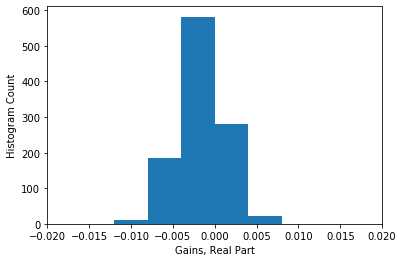

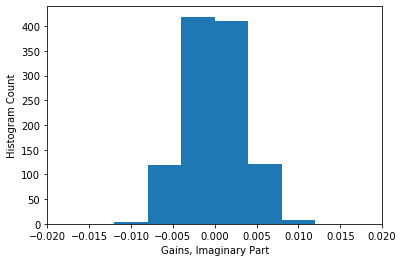

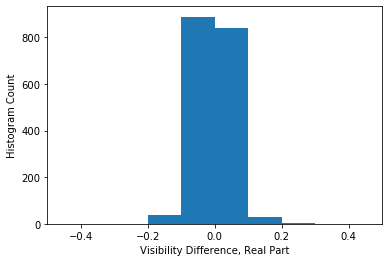

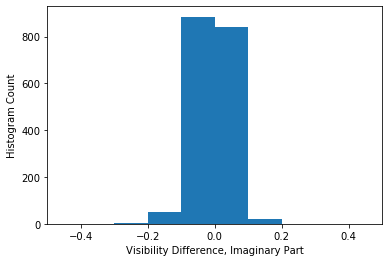

In [8]:
n_trials=30
method = 'Powell'
maxiter = 100000
data_stddev = .1

gain_vals = np.zeros((data_sim.Nants_data, n_trials), dtype=np.complex_)
vis_diff_vals = np.zeros((np.shape(baseline_groups)[0], n_trials), dtype=np.complex_)

for trial in range(n_trials):
    data_visibilities = (
        data_sim.data_array[:,0,0,0] 
        + np.random.normal(0, data_stddev, np.shape(data_sim.data_array[:,0,0,0])) 
        + 1j*np.random.normal(0, data_stddev, np.shape(data_sim.data_array[:,0,0,0]))
    )
    
    result = scipy.optimize.minimize(
        cost_function, x0, 
        args=(
            np.shape(baseline_groups)[0], data_sim.Nants_data, baseline_cov_inv, 
            model_visibilities, a_mat, gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev, model_stddev
        ),
        method=method, options={'maxiter':maxiter}
    )
    #print(result.message)
    gains_fit = result.x[:data_sim.Nants_data]+1j*result.x[data_sim.Nants_data:2*data_sim.Nants_data]
    # Ensure that the average angle is zero
    avg_angle = np.arctan2(np.mean(np.sin(np.angle(gains_fit))), np.mean(np.cos(np.angle(gains_fit))))
    gains_fit *= np.cos(avg_angle) - 1j*np.sin(avg_angle)
    gain_vals[:, trial] = gains_fit-1
    vis_fit = result.x[-2*np.shape(baseline_groups)[0]:-np.shape(baseline_groups)[0]]+1j*result.x[-np.shape(baseline_groups)[0]:]
    vis_fit_diff = vis_fit-model_visibilities_no_noise
    vis_diff_vals[:, trial] = vis_fit_diff

plot_range = .02
nbins = 10
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(gain_vals).flatten(), bins=bins)
plt.xlabel('Gains, Real Part')
plt.ylabel('Histogram Count')
plt.xlim(-plot_range,plot_range)
plt.show()

plt.hist(np.imag(gain_vals).flatten(), bins=bins)
plt.xlabel('Gains, Imaginary Part')
plt.ylabel('Histogram Count')
plt.xlim(-1*plot_range, plot_range)
plt.show()

plot_range = .5
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(vis_diff_vals).flatten(), bins=bins)
plt.xlabel('Visibility Difference, Real Part')
plt.ylabel('Histogram Count')
plt.xlim(-1*plot_range, plot_range)
plt.show()

plt.hist(np.imag(vis_diff_vals).flatten(), bins=bins)
plt.xlabel('Visibility Difference, Imaginary Part')
plt.ylabel('Histogram Count')
plt.xlim(-1*plot_range, plot_range)
plt.show()